# To download files and store them in google drive

In [ ]:
!cp '/content/drive/My Drive/Colab Notebooks/kaggle.json' kaggle.json
!pip -q uninstall -y kaggle
!pip -q install --upgrade pip
!pip -q install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

     |████████████████████████████████| 1.5MB 2.7MB/s 
     |████████████████████████████████| 59 kB 1.6 MB/s 


In [ ]:
!kaggle datasets download -d bulentsiyah/semantic-drone-dataset -p 'dataset'

100% 3.83G/3.83G [01:52<00:00, 32.0MB/s]
100% 3.83G/3.83G [01:52<00:00, 36.5MB/s]


In [ ]:
!mkdir '/content/drive/My Drive/Colab Notebooks/aerial_segmentation'

In [ ]:
!unzip -q '/content/dataset/semantic-drone-dataset.zip'

In [ ]:
!mv '/content/semantic_drone_dataset' '/content/drive/My Drive/Colab Notebooks/aerial_segmentation'

#Setting up the environment

In [ ]:
import os
import numpy as np
import pickle
from datetime import datetime
import time
import math 

from tqdm import tqdm
from collections import Counter

import cv2
from PIL import Image
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapOnImage
from imgaug.augmentables.heatmaps import HeatmapsOnImage

import albumentations as A
from albumentations.augmentations import transforms
from keras_segmentation.models.unet import unet

import tensorboard
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, SeparableConv2D, BatchNormalization as bn
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
%matplotlib inline

In [ ]:
!pip install keras-segmentation

## setting up tensorboard

In [ ]:
%load_ext tensorboard

In [ ]:
!rm -rf ./logs/ 

In [ ]:
logdir = 'logs/fit' + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
if False:
    #run this after training
    %tensorboard --logdir logs

# Working with data

In [ ]:
dsize = (576,576)

In [ ]:
images_dir_path = '/content/drive/My Drive/Colab Notebooks/aerial_segmentation/semantic_drone_dataset/original_images'
label_images_dir_path = '/content/drive/My Drive/Colab Notebooks/aerial_segmentation/semantic_drone_dataset/label_images_semantic'

In [ ]:
p_images = [os.path.join(images_dir_path, path) for path in os.listdir(images_dir_path)]
p_label_images = [os.path.join(label_images_dir_path, path) for path in os.listdir(label_images_dir_path)]
p_images.sort()
p_label_images.sort()
p_images[0], p_label_images[0], len(p_images), len(p_label_images)

('/content/drive/My Drive/Colab Notebooks/aerial_segmentation/semantic_drone_dataset/original_images/000.jpg',
 '/content/drive/My Drive/Colab Notebooks/aerial_segmentation/semantic_drone_dataset/label_images_semantic/000.png',
 400,
 400)

In [ ]:
masks = np.load('/content/drive/My Drive/Colab Notebooks/aerial_segmentation/semantic_drone_dataset/semantic_segmentation_masks.npy')

In [ ]:
xp_train, xp_val, y_train, y_val = train_test_split(p_images, masks, test_size = 0.2, random_state = 3)
del masks

In [ ]:
if False:
    with open('/content/drive/My Drive/Colab Notebooks/aerial_segmentation/resized_label_images.pkl', 'rb') as input:
        Y = pickle.load(input)
    Y = np.expand_dims(Y, axis = -1)

## helper function

In [ ]:
def show_all(img, masks, l_im = None):
    fig = plt.figure(figsize=(16, 16))
    cols = 6
    rows = 4
    for i in range(1, 24):
        fig.add_subplot(rows, cols, i)
        plt.imshow(masks[:, :, i-1])
    fig.add_subplot(4, 6, 24)
    plt.imshow(img)
    plt.show()  

In [ ]:
i_image = 1
img = np.asarray(Image.open(xp_train[i_image]))
mask = y_train[i_image]

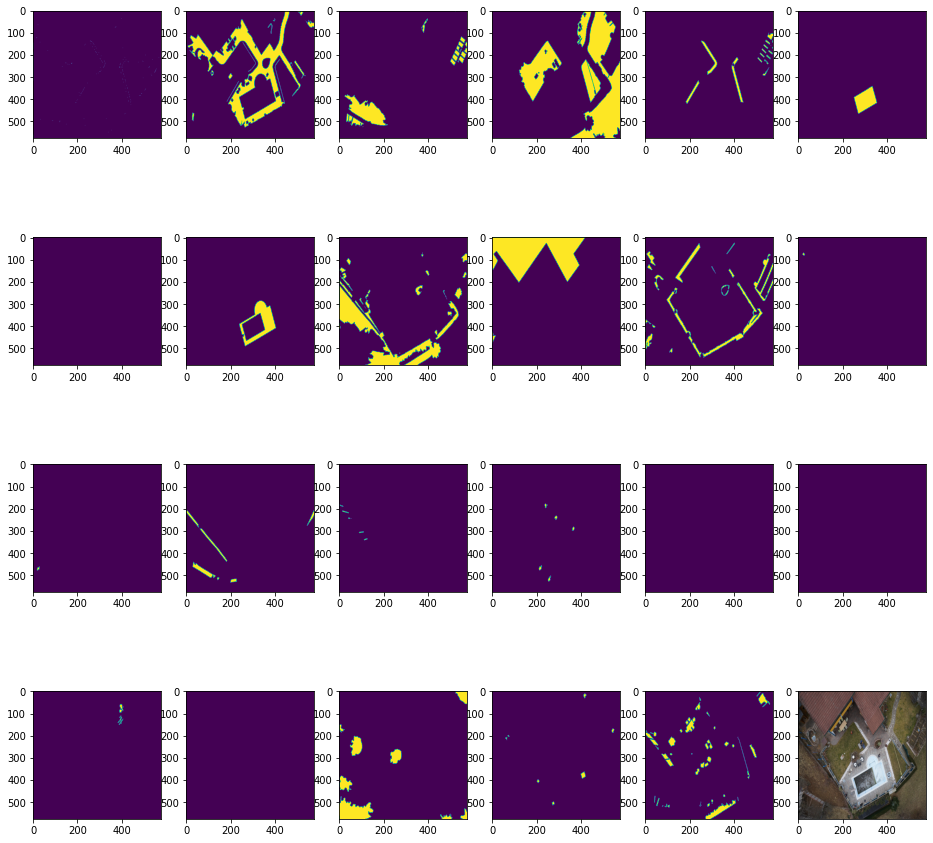

In [ ]:
show_all(cv2.resize(img, dsize), mask)

# Exploring data

## checking out the data and whether cv2 and pil works best


In [ ]:
img = cv2.imread(p_images[0])
l_im = cv2.imread(p_label_images[0])
l_im = l_im.astype(np.int32)
img.shape, l_im.shape

((4000, 6000, 3), (4000, 6000, 3))

In [ ]:
img = np.asarray(Image.open(p_images[0]))
l_im = np.asarray(Image.open(p_label_images[0]), dtype = np.float32)
img.shape, l_im.shape

((4000, 6000, 3), (4000, 6000))

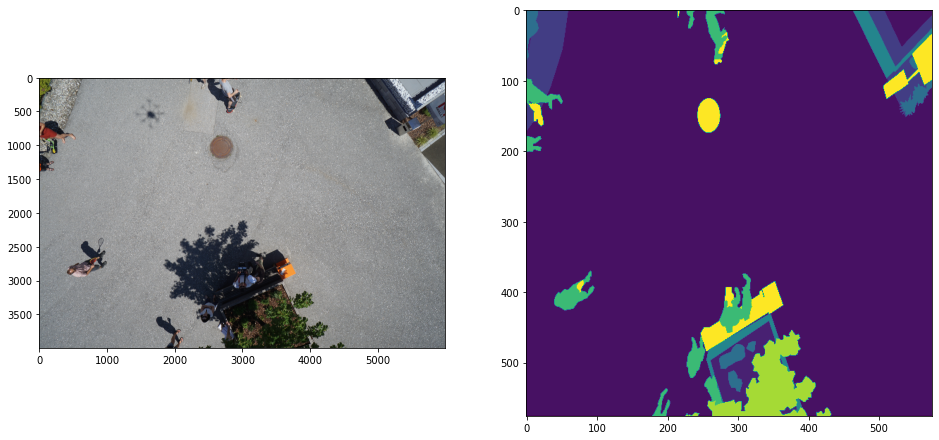

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (16,24))

axes[0].imshow(img)
axes[1].imshow(cv2.resize(l_im, dsize))

In [ ]:
cats = 'tree,grass,other vegetation,dirt,gravel,rocks,water,paved area,pool,person,dog,car,bicycle,roof,wall,fence,fence-pole,window,door,obstacle'
cats = cats.split(',')
cats = { k:v for k,v in zip(list(range(len(cats))), cats)}

In [ ]:
print(cats)

{0: 'tree', 1: 'grass', 2: 'other vegetation', 3: 'dirt', 4: 'gravel', 5: 'rocks', 6: 'water', 7: 'paved area', 8: 'pool', 9: 'person', 10: 'dog', 11: 'car', 12: 'bicycle', 13: 'roof', 14: 'wall', 15: 'fence', 16: 'fence-pole', 17: 'window', 18: 'door', 19: 'obstacle'}


## spliting up the segmentation into various classes for one image

In [ ]:
counter = dict(Counter(Y.flatten()))

In [ ]:
mask = np.zeros((1, dsize[0], dsize[1], 23))

In [ ]:
l_im = Y[0]
for i in range(23):
    for j in range(dsize[0]):
        for k in range(dsize[1]):
            if l_im[j, k] == i:
                mask[0, j, k, i] = 1

In [ ]:
mask.shape

(576, 576, 23)

In [ ]:
mask1 = np.load('/content/label_image_segmented/0.png.npy')
mask2 = np.load('/content/label_image_segmented/1.png.npy')
mask3 = np.load('/content/label_image_segmented/2.png.npy')
masks = np.stack([mask1, mask2, mask3], axis = 0)

In [ ]:
masks.shape

(400, 576, 576, 23)

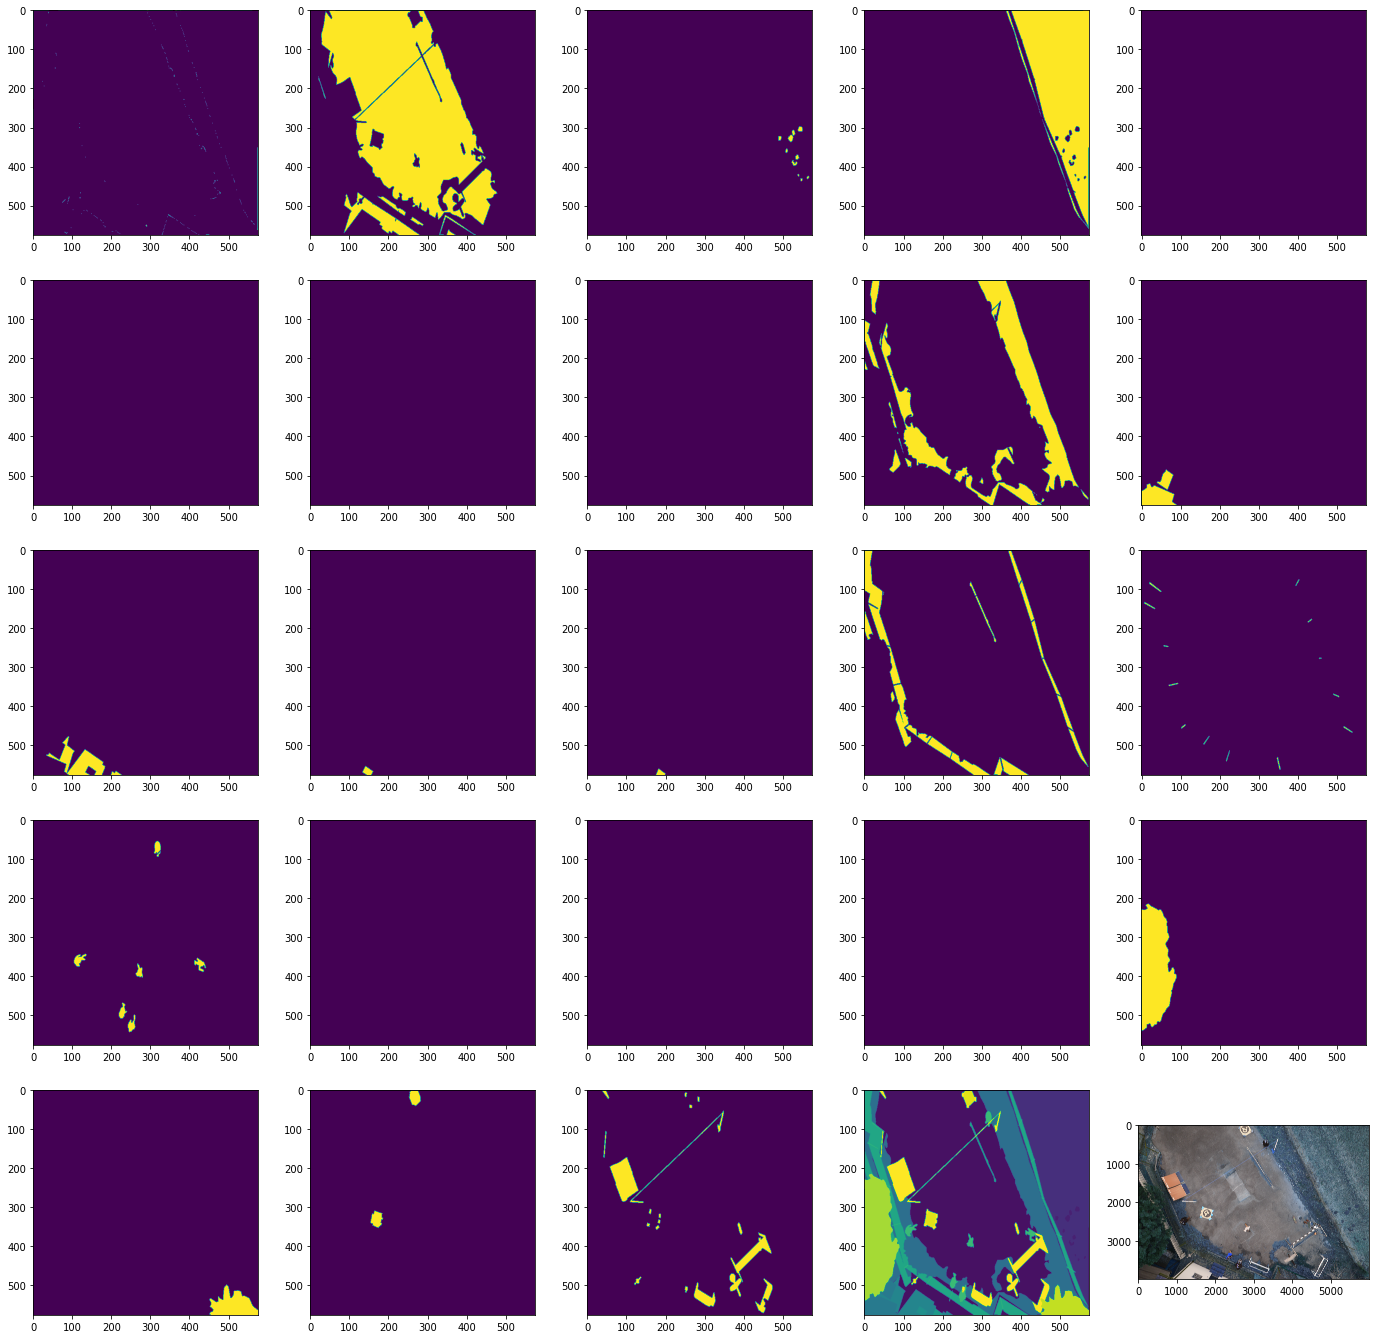

In [ ]:
i_image = 1
l_im = Y[i_image]
img = cv2.imread(p_images[i_image])
fig = plt.figure(figsize=(24, 24))
cols = 5
rows = 5
for i in range(1, 24):
  fig.add_subplot(rows, cols, i)
  plt.imshow(masks[i_image, :, :, i-1])
fig.add_subplot(5, 5, 24)
plt.imshow(np.squeeze(l_im))
fig.add_subplot(5, 5, 25)
plt.imshow(img)
plt.show()  

## splitting up for all segmentation masks

In [ ]:
masks = np.zeros((400, dsize[0], dsize[1], 23), dtype = np.int8)
for n in tqdm(range(400)):
    l_im = Y[n]
    for j in range(dsize[0]):
        for k in range(dsize[1]):
            masks[n, j, k, int(l_im[j, k])] = 1

100%|██████████| 400/400 [01:33<00:00,  4.27it/s]


In [ ]:
np.save('semantic_segmentation_masks', masks)

In [ ]:
!cp semantic_segmentation_masks.npy '/content/drive/My Drive/Colab Notebooks/aerial_segmentation/semantic_drone_dataset'

## visualizing data

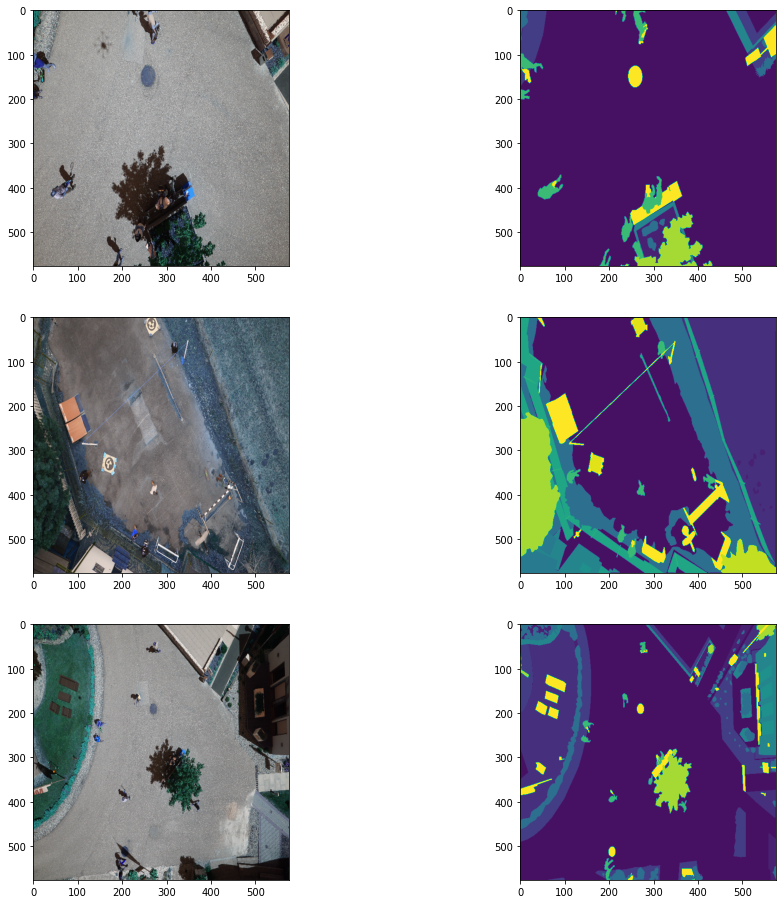

In [ ]:
n = 3
fig, axes = plt.subplots(n, 2, figsize = (16,16))
for i in range(n):
    axes[i, 0].imshow(X[i]/255.0)
    axes[i, 1].imshow(Y[i])


# Resizing Images

In [ ]:
dsize = 576, 576
X = np.zeros((len(p_images), dsize[0], dsize[1], 3))
for i, p in tqdm(enumerate(p_images)):
    img = cv2.imread(p)
    img = cv2.resize(img, dsize)
    X[i] = img

400it [16:21,  2.45s/it]


In [ ]:
with open('resized_images.pkl', 'wb') as output:
    pickle.dump(X, output, protocol = pickle.HIGHEST_PROTOCOL)

In [ ]:
!cp resized_images.pkl '/content/drive/My Drive/Colab Notebooks/aerial_segmentation'

400it [03:23,  1.97it/s]


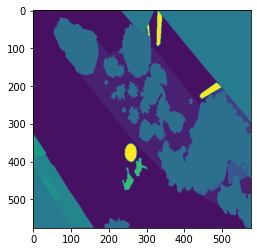

In [ ]:
dsize = 576, 576
Y = np.zeros((len(p_label_images), dsize[0], dsize[1]))
for j, p in tqdm(enumerate(p_label_images)):
    img = np.asarray(Image.open(p), dtype=np.float32)
    #print(img)
    img = cv2.resize(img, dsize, interpolation = cv2.INTER_NEAREST)
    #print(img)
    plt.imshow(img)
    #print(img.shape)
    Y[j] = img

In [ ]:
with open('resized_label_images.pkl', 'wb') as output:
    pickle.dump(Y, output, protocol = pickle.HIGHEST_PROTOCOL)

In [ ]:
!cp resized_label_images.pkl '/content/drive/My Drive/Colab Notebooks/aerial_segmentation'

# Data Augmentation

## trying imgaug

In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapOnImage
from imgaug.augmentables.heatmaps import HeatmapsOnImage

In [ ]:
ia.seed(1)

seq = iaa.Sequential([
                      #iaa.Dropout([0.05, 0.2]),
                      #iaa.Sharpen((0.0, 1.0)),
                      iaa.Affine(rotate=(-45,45)),
                      #iaa.ElasticTransformation(alpha = 50, sigma = 5),
                      #iaa.Fliplr(p = 0.5),
                      #iaa.Flipud(0.5),
                      #iaa.GaussianBlur((0.5, 1.5)),
                      #iaa.LinearContrast((0.75, 1.5)),
                      #iaa.AdditiveGaussianNoise(loc = 0, scale = (0.0, 0.05 * 255), per_channel=0.5),
                      #iaa.Multiply((0.8, 1.2), per_channel=0.2)
                    ])

In [ ]:
train_gen = full_datagen(xp_train, yp_train)

In [ ]:
image, map = next(train_gen)
image, map = image[0], map[0]
map = np.expand_dims(map, axis = -1)
segmap = SegmentationMapOnImage(map, shape=(image.shape))
depth = HeatmapsOnImage(map.astype(np.float32), shape = (image.shape), min_value=0.0, max_value=22.0)
image_aug_1, map_aug_1 = seq(image = image, segmentation_maps = segmap)
image_aug_2, map_aug_2 = seq(image = image, heatmaps = depth)

/usr/local/lib/python3.6/dist-packages/imgaug/augmentables/heatmaps.py:54: UserWarning: Value range of heatmap was chosen to be (0.00000000, 1.00000000), but found actual min/max of (0.00000000, 22.00000000). Array will be clipped to chosen value range.
  min_value, max_value, np.min(arr), np.max(arr)))


In [ ]:
image_aug_1.shape[:2]

(576, 576)

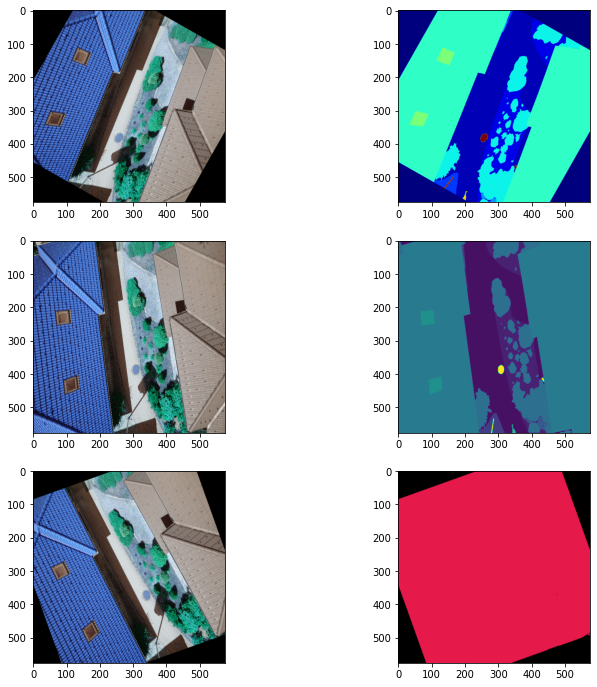

In [ ]:
fig, axes = plt.subplots(3, 2, figsize = (12,12))

axes[0, 0].imshow(image_aug_2)
axes[0, 1].imshow(map_aug_2.draw(size = image_aug_2.shape[:2])[0])
axes[1, 0].imshow(image)
axes[1, 1].imshow(np.squeeze(map, axis = -1))
axes[2, 0].imshow(image_aug_1)
#axes[2, 1].imshow(map_aug_1.draw_on_image(image_aug_1))[0]
axes[2, 1].imshow(map_aug_1.draw(size = image_aug_1.shape[:2]))

## trying Albumentations

In [ ]:
import albumentations as A
from albumentations.augmentations import transforms

In [ ]:
train_gen = full_datagen(xp_train, yp_train)

In [ ]:
image, map = next(train_gen)
image, map = image[0], map[0]

In [ ]:
augmented = aug(image = image, mask = map)
image_aug = augmented['image']
map_aug = augmented['mask']

ValueError: ignored

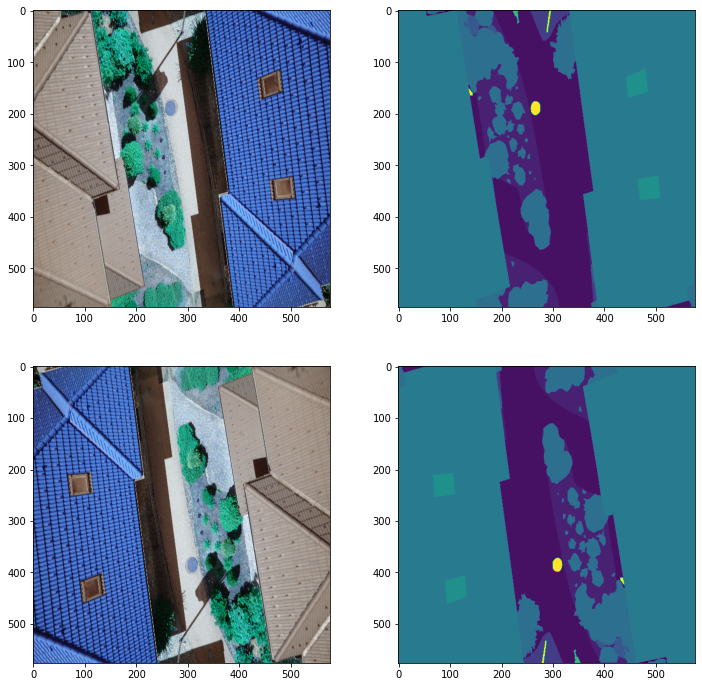

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (12,12))

axes[0, 0].imshow(image_aug)
axes[0, 1].imshow(map_aug)
axes[1, 0].imshow(image)
axes[1, 1].imshow(map)

# Datagenerator

## augmentor

In [ ]:
def get_augmentor(p = 0.2):
    transform = A.Compose([
                    A.Resize(576, 576, always_apply=True),
                    A.HorizontalFlip(p = p),
                    A.VerticalFlip(p = p), 
                    A.GridDistortion(p = p),
                    A.IAAAffine(rotate=15.0, p = p, mode = 'constant'),
                    #A.ElasticTransform(alpha=30, sigma=7, p = p, border_mode=cv2.BORDER_CONSTANT),
                    A.RandomBrightnessContrast((0,0.5),(0,0.5), p = p),
                    transforms.GaussNoise(var_limit=(10, 50), p = p),
                    ])
    return transform

In [ ]:
transform = get_augmentor()

## full_datagen and val datagen

In [ ]:
def full_datagen(x_p, y_p, dsize = (576, 576)):
    X = np.zeros((1, dsize[0], dsize[1], 3))
    Y = np.zeros((1, dsize[0], dsize[1]))
    while True:
        for p, lp in zip(x_p, y_p):
            img = cv2.imread(p)
            mask = np.asarray(Image.open(lp), dtype=np.float32)
            augmented = transform(image = img, mask = mask)
            X[0] = augmented['image']/255.
            Y[0] = augmented['mask']
            yield X, Y

In [ ]:
def val_datagen(x_p, y_p, dsize = (576, 576)):
    X = np.zeros((1, dsize[0], dsize[1], 3))
    Y = np.zeros((1, dsize[0], dsize[1], 23))
    while True:
        for p, lp in zip(x_p, y_p):
            img = cv2.imread(p)
            mask = np.asarray(Image.open(lp), dtype=np.float32)
            img = cv2.resize(img, dsize)
            mask = cv2.resize(mask, dsize)
            X[0] = img/255.0
            Y[0] = mask
            yield X, Y

In [ ]:
X, Y, img, mask = next(train_gen)

fig, axes = plt.subplots(2, 2, figsize = (12,12))

axes[0, 0].imshow(X[0])
axes[0, 1].imshow(Y[0])
axes[1, 0].imshow(img)
axes[1, 1].imshow(mask)

In [ ]:
val_gen = val_datagen(xp_test, yp_test)
img, l_im = next(val_gen)

fig, axes = plt.subplots(1, 2, figsize = (12,12))

axes[0].imshow(img)
axes[1].imshow(l_im)

# Keras Batch generator

In [ ]:
def get_augmentor(p = 0.2):
    transform = A.Compose([
                    A.Resize(576, 576, always_apply=True),
                    A.HorizontalFlip(p = p),
                    A.VerticalFlip(p = p), 
                    A.GridDistortion(p = p),
                    A.IAAAffine(rotate=15.0, p = p, mode = 'constant'),
                    #A.ElasticTransform(alpha=30, sigma=7, p = p, border_mode=cv2.BORDER_CONSTANT),
                    A.RandomBrightnessContrast((0,0.5),(0,0.5), p = p),
                    transforms.GaussNoise(var_limit=(10, 50), p = p),
                    ])
    return transform

In [ ]:
class SimpleBatchGenerator(Sequence):
    def __init__(self, x_dir, y, batch_size, p, start_heavy_aug_epoch, heavy_p = 0.5, get_augmentor = get_augmentor, dsize = (576, 576), mask_dsize = (576, 576)):
        self.x_dir = x_dir
        self.y = y
        self.batch_size = batch_size
        self.dsize = dsize
        self.mask_dsize = mask_dsize
        self.p = p
        self.aug = get_augmentor(self.p)
        self.start_heavy_aug_epoch = start_heavy_aug_epoch
        self.num_epochs_done = 0
        self.heavy_p = heavy_p
        self.get_augmentor = get_augmentor

    def __len__(self):
        return int(math.ceil(self.y.shape[0]//self.batch_size))
    
    def __getitem__(self, idx):
        lb = idx * self.batch_size          
        rb = (idx + 1) * self.batch_size

        if rb > self.y.shape[0]:
            rb = self.y.shape[0]
            lb = rb - self.batch_size

        instance_count = 0

        x_batch = np.zeros((rb - lb, self.dsize[0], self.dsize[1], 3))
        y_batch = np.zeros((rb - lb, self.mask_dsize[0], self.mask_dsize[1], 23))

        for t in range(lb, rb):
            img = cv2.imread(self.x_dir[t])
            mask = self.y[t]
            augmented = self.aug(image = img, mask = mask)
            x_batch[instance_count] = augmented['image']/255.
            if self.mask_dsize == self.dsize:
                y_batch[instance_count] = augmented['mask']
            else:   y_batch[instance_count] = cv2.resize(augmented['mask'].astype(np.float32), self.mask_dsize).astype(np.int8)
            instance_count += 1
            
        return x_batch, y_batch

    def on_epoch_end(self):
        self.num_epochs_done = self.num_epochs_done + 1
        if self.num_epochs_done >= self.start_heavy_aug_epoch:
            self.aug = self.get_augmentor(self.heavy_p)


### testing batch_generator

In [ ]:
train_batch_generator = SimpleBatchGenerator(xp_train, y_train, 2, p = 0.5, start_heavy_aug_epoch=15, mask_dsize=(288,288))

In [ ]:
x_batch, y_batch = train_batch_generator.__getitem__(1)

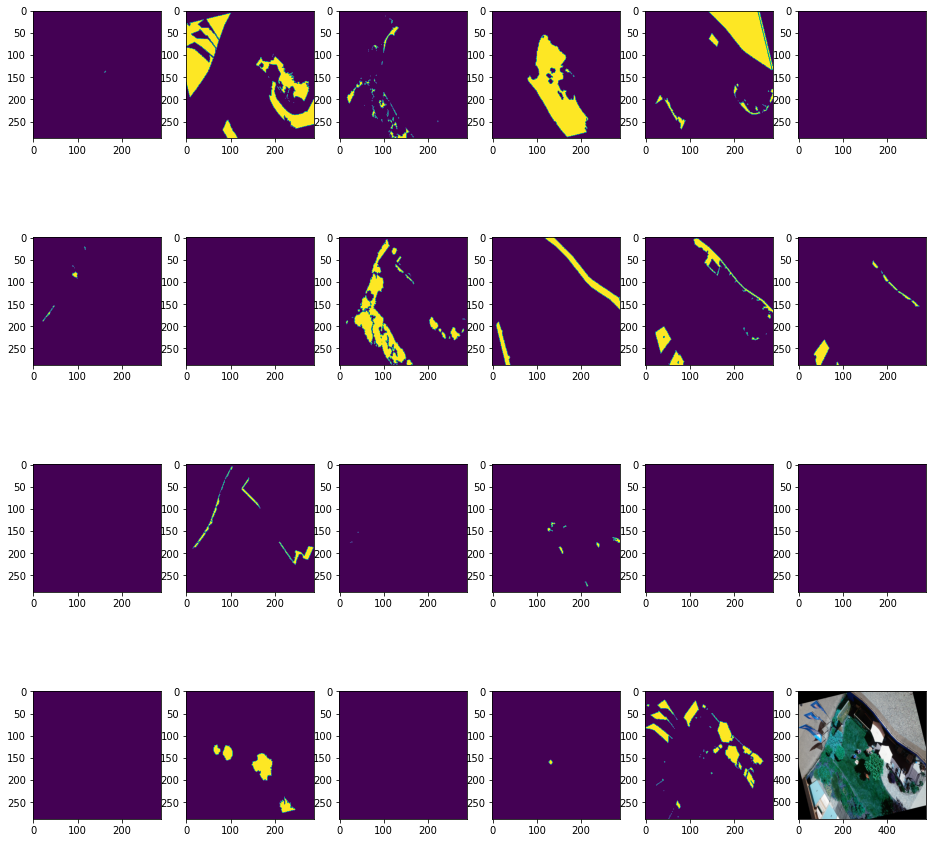

In [ ]:
show_all(x_batch[0], y_batch[0])

# Unet model

In [ ]:
n = 64

inputs = Input((576, 576, 3))

conv1_1 = Conv2D(n, (3, 3), activation = 'relu', padding = 'same')(inputs)
conv1_2 = Conv2D(n, (3, 3), activation = 'relu', padding = 'same')(conv1_1) #576
BN1 = bn()(conv1_2)
pool1 = MaxPooling2D((2,2))(BN1) # 288
drop1 = Dropout(0.25)(pool1)

conv2_1 = Conv2D(n * 2, (3, 3), activation = 'relu', padding = 'same')(drop1)
conv2_2 = Conv2D(n * 2, (3, 3), activation = 'relu', padding = 'same')(conv2_1) #288
BN2 = bn()(conv2_2)
pool2 = MaxPooling2D((2,2))(BN2) #144
drop2 = Dropout(0.5)(pool2)

conv3_1 = Conv2D(n * 4, (3, 3), activation = 'relu', padding = 'same')(drop2)
conv3_2 = Conv2D(n * 4, (3, 3), activation = 'relu', padding = 'same')(conv3_1) #144
BN3 = bn()(conv3_2)
pool3 = MaxPooling2D((2,2))(BN3) #72
drop3 = Dropout(0.5)(pool3)

conv4_1 = Conv2D(n * 8, (3, 3), activation = 'relu', padding = 'same')(drop3)
conv4_2 = Conv2D(n * 8, (3, 3), activation = 'relu', padding = 'same')(conv4_1) #72
BN4 = bn()(conv4_2)
pool4 = MaxPooling2D((2,2))(BN4) #36
drop4 = Dropout(0.5)(pool4)

conv5_1 = Conv2D(n * 16, (3, 3), activation = 'relu', padding = 'same')(drop4)
conv5_2 = Conv2D(n * 16, (3, 3), activation = 'relu', padding = 'same')(conv5_1) #36
BN5 = bn()(conv5_2)
uconv4 = Conv2DTranspose(n * 8, kernel_size=(3,3), strides = (2,2), padding='same', activation = 'relu')(BN5) #72
concat4 = concatenate([conv4_2, uconv4])

conv4_3 = Conv2D(n * 4, (3, 3), activation = 'relu', padding = 'same')(concat4)
conv4_4 = Conv2D(n * 4, (3, 3), activation = 'relu', padding = 'same')(conv4_3) #72
BN6 = bn()(conv4_4)
uconv3 = Conv2DTranspose(n * 2, kernel_size=(3,3), strides = (2,2), padding='same', activation = 'relu')(BN6) #144
concat3 = concatenate([conv3_2, uconv3])
drop5 = Dropout(0.5)(concat3)

conv3_3 = Conv2D(n * 2, (3, 3), activation = 'relu', padding = 'same')(drop5)
conv3_4 = Conv2D(n * 2, (3, 3), activation = 'relu', padding = 'same')(conv3_3) #144
BN7 = bn()(conv3_4)
uconv2 = Conv2DTranspose(n * 2, kernel_size=(3,3), strides = (2,2), padding='same', activation = 'relu')(BN7) #288
concat2 = concatenate([conv2_2, uconv2])
drop6 = Dropout(0.5)(concat2)

conv2_3 = Conv2D(n, (3, 3), activation = 'relu', padding = 'same')(drop6)
conv2_4 = Conv2D(n, (3, 3), activation = 'relu', padding = 'same')(conv2_3) #288
BN8 = bn()(conv2_4)
uconv1 = Conv2DTranspose(n * 2, kernel_size=(3,3), strides = (2,2), padding='same', activation = 'relu')(BN8) #576
concat1 = concatenate([conv1_2, uconv1])

outputs = SeparableConv2D(23, (1,1), activation='softmax')(concat1)

model = tf.keras.Model(inputs, outputs)

In [ ]:
unet_model = unet(n_classes=23, input_height=576, input_width=576)

In [ ]:
activation = tf.keras.activations.softmax(unet_model.layers[-3].output)
unet_model1 = Model(inputs = unet_model.input, outputs = activation)

## visualizing the model

In [ ]:
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(unet_model1, 'unet_model.png', show_shapes=True)

# Training model from scratch

In [ ]:
adam = Adam(learning_rate = 1e-3)

mc = ModelCheckpoint(f'model_{int(time.time())%100}.h5', monitor='loss', verbose = 1, save_best_only=True, save_weights_only=True)
es = EarlyStopping(monitor = 'loss', min_delta = 0.001, patience = 5, verbose = 1, restore_best_weights = True)
rlr = ReduceLROnPlateau(monitor = 'loss',  factor = .5, patience = 3, verbose = 1, min_delta=0.05, min_lr = 1e-6)

model.compile(optimizer=adam, loss = 'categorical_crossentropy', run_eagerly=True)

In [ ]:
train_batch_generator = SimpleBatchGenerator(xp_train, y_train, 1, p = 0.2, start_heavy_aug_epoch=10)
val_batch_generator = SimpleBatchGenerator(xp_val, y_val, 1, p = 0.0, heavy_p = 0.0, start_heavy_aug_epoch=10000)

In [ ]:
history = model.fit(train_batch_generator, steps_per_epoch = len(train_batch_generator),
          batch_size = 1, epochs = 30,
          callbacks = [es, rlr, mc],
          validation_data = val_batch_generator,
          validation_steps = len(val_batch_generator)
          )

Epoch 1/30
320/320 [==============================] - ETA: 0s - loss: 2.0158
Epoch 00001: loss improved from inf to 2.01581, saving model to model_16.h5
320/320 [==============================] - 913s 3s/step - loss: 2.0158 - val_loss: 1.7543
Epoch 2/30
320/320 [==============================] - ETA: 0s - loss: 1.7534
Epoch 00002: loss improved from 2.01581 to 1.75337, saving model to model_16.h5
320/320 [==============================] - 285s 890ms/step - loss: 1.7534 - val_loss: 1.6088
Epoch 3/30
320/320 [==============================] - ETA: 0s - loss: 1.6469
Epoch 00003: loss improved from 1.75337 to 1.64688, saving model to model_16.h5
320/320 [==============================] - 289s 902ms/step - loss: 1.6469 - val_loss: 5.1900
Epoch 4/30
320/320 [==============================] - ETA: 0s - loss: 1.5562
Epoch 00004: loss improved from 1.64688 to 1.55622, saving model to model_16.h5
320/320 [==============================] - 286s 893ms/step - loss: 1.5562 - val_loss: 1.9292
Epoch 5

In [ ]:
%tensorboard --logdir logs

In [ ]:
!cp model_16.h5 '/content/drive/My Drive/Colab Notebooks/aerial_segmentation/'

In [ ]:
!cp '/content/drive/My Drive/Colab Notebooks/aerial_segmentation/model.h5' model.h5

# Training unet_model1

In [ ]:
adam = Adam(learning_rate = 1e-3)

mc = ModelCheckpoint(f'model_{int(time.time())%100}.h5', monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=True)
es = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 5, verbose = 1, restore_best_weights = True)
rlr = ReduceLROnPlateau(monitor = 'val_loss',  factor = .5, patience = 3, verbose = 1, min_delta=0.05, min_lr = 1e-6)

unet_model1.compile(optimizer=adam, loss = 'categorical_crossentropy', run_eagerly=True)

In [ ]:
train_batch_generator = SimpleBatchGenerator(xp_train, y_train, 1, p = 0.2, start_heavy_aug_epoch=10, mask_dsize=(288, 288))
val_batch_generator = SimpleBatchGenerator(xp_val, y_val, 1, p = 0.0, heavy_p = 0.0, start_heavy_aug_epoch=10000, mask_dsize=(288, 288))

In [ ]:
history = unet_model1.fit(train_batch_generator, steps_per_epoch = len(train_batch_generator),
          batch_size = 1, epochs = 30,
          callbacks = [es, rlr, mc],
          validation_data = val_batch_generator,
          validation_steps = len(val_batch_generator)
          )

Epoch 1/30
320/320 [==============================] - ETA: 0s - loss: 1.8415
Epoch 00001: val_loss improved from inf to 2.09307, saving model to model_85.h5
320/320 [==============================] - 944s 3s/step - loss: 1.8415 - val_loss: 2.0931
Epoch 2/30
320/320 [==============================] - ETA: 0s - loss: 1.4341
Epoch 00002: val_loss improved from 2.09307 to 1.47688, saving model to model_85.h5
320/320 [==============================] - 240s 750ms/step - loss: 1.4341 - val_loss: 1.4769
Epoch 3/30
320/320 [==============================] - ETA: 0s - loss: 1.3447
Epoch 00003: val_loss did not improve from 1.47688
320/320 [==============================] - 234s 730ms/step - loss: 1.3447 - val_loss: 2.0645
Epoch 4/30
320/320 [==============================] - ETA: 0s - loss: 1.2754
Epoch 00004: val_loss did not improve from 1.47688
320/320 [==============================] - 239s 747ms/step - loss: 1.2754 - val_loss: 1.9368
Epoch 5/30
320/320 [==============================] - ETA

In [ ]:
%tensorboard --logdir logs

In [ ]:
!cp model_16.h5 '/content/drive/My Drive/Colab Notebooks/aerial_segmentation/'

In [ ]:
!cp '/content/drive/My Drive/Colab Notebooks/aerial_segmentation/model.h5' model.h5

# testing

In [ ]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/aerial_segmentation/model_16.h5')

In [ ]:
train_batch_generator = SimpleBatchGenerator(xp_train, y_train, 1, p = 0.2, start_heavy_aug_epoch=10, mask_dsize=(288, 288))
val_batch_generator = SimpleBatchGenerator(xp_val, y_val, 1, p = 0.0, heavy_p = 0.0, start_heavy_aug_epoch=10000, mask_dsize=(288, 288))

In [ ]:
x_test, y_test = val_batch_generator.__getitem__(2)

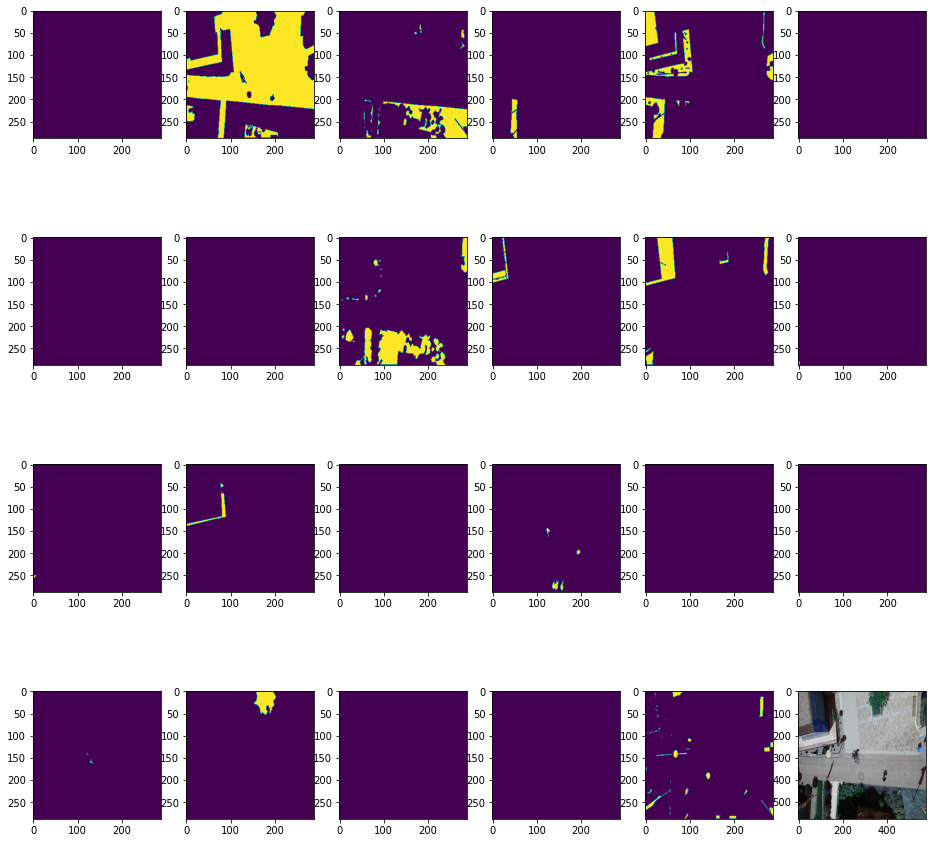

************************************************************************************************************************


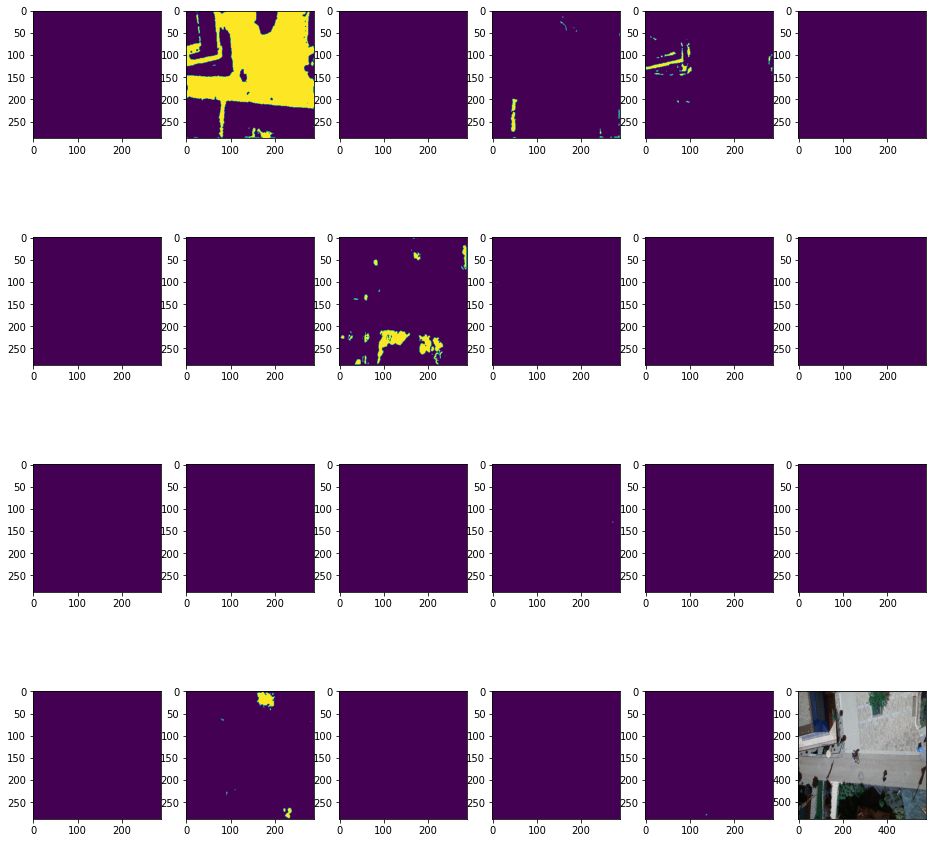

In [ ]:
y_pred = unet_model1.predict(x_test)
y_pred_processed = np.round(y_pred[0], decimals=0)
show_all(x_test[0], y_test[0])
print('*' * 120)
show_all(x_test[0], y_pred_processed)

In [ ]:
unet_model1.evaluate(val_batch_generator, steps=len(val_batch_generator))

80/80 [==============================] - 37s 462ms/step - loss: 1.2659


1.2659467458724976

In [ ]:
!cp model_85.h5 '/content/drive/My Drive/Colab Notebooks/aerial_segmentation' 